# YOLOv10 Custom training
Jupyter notebook used to train custom model on Google CoLab for specific application


In [1]:
#Define Session
import os
HOME = os.getcwd()

SESSION_NAME    = 'cattleRun'
MODEL_PATH      = f'{HOME}/weights/yolov10n.pt'

## Enable GPU acceleration
Navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

In [2]:
#Check if GPU is active
!nvidia-smi

Wed Aug  7 17:38:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install YOLOv10

In [3]:
# Clone YOLOv10 from Github
!pip install -q git+https://github.com/THU-MIG/yolov10.git

# Download pretrained weights
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
total 408M
-rw-r--r-- 1 root root  80M May 26 15:53 yolov10b.pt
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt
-rw-r--r-- 1 root root  64M May 26 15:54 yolov10m.pt
-rw-r--r-- 1 root root  11M May 26 15:54 yolov10n.pt
-rw-r--r-- 1 root root  32M May 26 15:54 yolov10s.pt
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


## Download Dataset

In [4]:
#Clear Dataset folder
!rm -rf {HOME}/datasets

#Create Dataset folder
!mkdir -p {HOME}/datasets
os.chdir(f'{HOME}/datasets')

#Download dataset
!pip install -q roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="s5hUTd4Qg29gKyz5y0ed")
project = rf.workspace("greenko-it9ht").project("animal-detection-wc5gl")
version = project.version(5)
dataset = version.download("yolov8")


#Correct YAML file for correct val,train and test directories
DATASET_YAML_PATH    = f'{dataset.location}/data.yaml'
!grep -v 'val:' {dataset.location}/data.yaml > {dataset.location}/data_temp.yaml && mv {dataset.location}/data_temp.yaml {dataset.location}/data.yaml
!grep -v 'train:' {dataset.location}/data.yaml > {dataset.location}/data_temp.yaml && mv {dataset.location}/data_temp.yaml {dataset.location}/data.yaml
!grep -v 'test:' {dataset.location}/data.yaml > {dataset.location}/data_temp.yaml && mv {dataset.location}/data_temp.yaml {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {DATASET_YAML_PATH}
#Go back to home directory
os.chdir(f'{HOME}')

#SAve Paths
DATASET_DIR = dataset.location
DATASET_YAML_PATH    = f'{dataset.location}/data.yaml'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.4 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to animal-detection-5 in yolov8:: 100%|██████████| 1365/1365 [00:00<00:00, 5097.26it/s]


## Custom Training

In [5]:
%cd {HOME}

from datetime import datetime
from ultralytics import YOLOv10

#Session Variables
T_STAMP         = datetime.now().strftime('%Y%m%d-%H:%M')
RUN_NAME        = SESSION_NAME + '-' + T_STAMP

#Create Output Path
RUNS_PATH       = os.path.join(HOME, 'runs')
SESSION_PATH    = os.path.join(RUNS_PATH, SESSION_NAME)
OUTPUT_PATH     = os.path.join(SESSION_PATH, RUN_NAME)

#Create YOLOv10 model
model           = YOLOv10(MODEL_PATH)

#Train the model
train = model.train(
        #Train Settings
        model=MODEL_PATH, 	          #Specifies the model file for training.
        data=DATASET_YAML_PATH,       #Path to the dataset configuration file (e.g., coco8.yaml).
        epochs=5, 	                  #Total number of training epochs.
        time=None, 	                  #Maximum training time in hours.
        patience=100, 	              #Number of epochs to wait without improvement in validation metrics before early stopping the training.
        batch=-1, 	                  #Batch size, with three modes: set as an integer (e.g., batch=16), auto mode for 60% GPU memory utilization (batch=-1), or auto mode with specified utilization fraction (batch=0.70).
        imgsz=640, 	                  #Target image size for training.

        save=True, 	                  #Enables saving of training checkpoints and final model weights.
        save_period=-1, 	            #Frequency of saving model checkpoints, specified in epochs.
        cache=False, 	                #Enables caching of dataset images in memory (True/ram), on disk (disk), or disables it (False).
        device=None, 	                  #Specifies the computational device(s) for training
        workers=8, 	                  #Number of worker threads for data loading (per RANK if Multi-GPU training).
        project=SESSION_PATH, 	      #Name of the project directory where training outputs are saved.
        name=RUN_NAME, 	              #Name of the training run.
        exist_ok=False, 	            #If True, allows overwriting of an existing project/name directory.
        pretrained=True,	            #Determines whether to start training from a pretrained model.

        optimizer='auto', 	          #Choice of optimizer for training.
        verbose=False, 	              #Enables verbose output during training, providing detailed logs and progress updates.
        seed=0, 	                    #Sets the random seed for training, ensuring reproducibility of results across runs with the same configurations.
        deterministic=True, 	        #Forces deterministic algorithm use, ensuring reproducibility but may affect performance and speed due to the restriction on non-deterministic algorithms.
        single_cls=False, 	          #Treats all classes in multi-class datasets as a single class during training.
        rect=False, 	                #Enables rectangular training, optimizing batch composition for minimal padding. Can improve efficiency and speed but may affect model accuracy.
        cos_lr=False,	                #Utilizes a cosine learning rate scheduler, adjusting the learning rate following a cosine curve over epochs. Helps in managing learning rate for better convergence.
        close_mosaic=10, 	            #Disables mosaic data augmentation in the last N epochs to stabilize training before completion. Setting to 0 disables this feature.
        resume=False, 	              #Resumes training from the last saved checkpoint. Automatically loads model weights, optimizer state, and epoch count, continuing training seamlessly.
        amp=True, 	                  #Enables Automatic Mixed Precision (AMP) training, reducing memory usage and possibly speeding up training with minimal impact on accuracy.
        fraction=1.0, 	              #Specifies the fraction of the dataset to use for training. Allows for training on a subset of the full dataset, useful for experiments or when resources are limited.
        profile=False, 	              #Enables profiling of ONNX and TensorRT speeds during training, useful for optimizing model deployment.

        freeze=None,          	      #Freezes the first N layers of the model or specified layers by index, reducing the number of trainable parameters. Useful for fine-tuning or transfer learning.
        lr0=0.01, 	                  #Initial learning rate (i.e. SGD=1E-2, Adam=1E-3) . Adjusting this value is crucial for the optimization process, influencing how rapidly model weights are updated.
        lrf=0.1, 	                    #Final learning rate as a fraction of the initial rate = (lr0 * lrf), used in conjunction with schedulers to adjust the learning rate over time.
        momentum=0.937, 	            #Momentum factor for SGD or beta1 for Adam optimizers, influencing the incorporation of past gradients in the current update.
        weight_decay=0.0005, 	        #L2 regularization term, penalizing large weights to prevent overfitting.
        warmup_epochs=3.0, 	          #Number of epochs for learning rate warmup, gradually increasing the learning rate from a low value to the initial learning rate to stabilize training early on.
        warmup_momentum=0.8, 	        #Initial momentum for warmup phase, gradually adjusting to the set momentum over the warmup period.
        warmup_bias_lr=0.1, 	        #Learning rate for bias parameters during the warmup phase, helping stabilize model training in the initial epochs.

        box=7.5, 	                    #Weight of the box loss component in the loss function, influencing how much emphasis is placed on accurately predicting bounding box coordinates.
        cls=0.5, 	                    #Weight of the classification loss in the total loss function, affecting the importance of correct class prediction relative to other components.
        dfl=1.5, 	                    #Weight of the distribution focal loss, used in certain YOLO versions for fine-grained classification.
        pose=12.0, 	                  #Weight of the pose loss in models trained for pose estimation, influencing the emphasis on accurately predicting pose keypoints.
        kobj=2.0, 	                  #Weight of the keypoint objectness loss in pose estimation models, balancing detection confidence with pose accuracy.
        label_smoothing=0.0, 	        #Applies label smoothing, softening hard labels to a mix of the target label and a uniform distribution over labels, can improve generalization.
        nbs=64, 	                    #Nominal batch size for normalization of loss.

        overlap_mask=True, 	          #Determines whether segmentation masks should overlap during training, applicable in instance segmentation tasks.
        mask_ratio=4, 	              #Downsample ratio for segmentation masks, affecting the resolution of masks used during training.
        dropout=0.0, 	                #Dropout rate for regularization in classification tasks, preventing overfitting by randomly omitting units during training.
        val=True, 	                  #Enables validation during training, allowing for periodic evaluation of model performance on a separate dataset.
        plots=True,	                  #Generates and saves plots of training and validation metrics, as well as prediction examples, providing visual insights into model performance and learning progression.

        #Augmentation Arguments
        hsv_h=0.015,                  #Adjusts the hue of the image by a fraction of the color wheel, introducing color variability. Helps the model generalize across different lighting conditions.
        hsv_s=0.7,                    #Alters the saturation of the image by a fraction, affecting the intensity of colors. Useful for simulating different environmental conditions.
        hsv_v=0.4,                    #Modifies the value (brightness) of the image by a fraction, helping the model to perform well under various lighting conditions.
        degrees=0.0,                  #Rotates the image randomly within the specified degree range, improving the model's ability to recognize objects at various orientations.
        translate=0.1,                #Translates the image horizontally and vertically by a fraction of the image size, aiding in learning to detect partially visible objects.

        scale=0.5,                    #Scales the image by a gain factor, simulating objects at different distances from the camera.
        shear=0.0,                    #Shears the image by a specified degree, mimicking the effect of objects being viewed from different angles.
        perspective=0.0,              #Applies a random perspective transformation to the image, enhancing the model's ability to understand objects in 3D space.
        flipud=0.0,                   #Flips the image upside down with the specified probability, increasing the data variability without affecting the object's characteristics.
        fliplr=0.5,                   #Flips the image left to right with the specified probability, useful for learning symmetrical objects and increasing dataset diversity.

        bgr=0.0, 	                    #Flips the image channels from RGB to BGR with the specified probability, useful for increasing robustness to incorrect channel ordering.
        mosaic=1.0, 	                #Combines four training images into one, simulating different scene compositions and object interactions. Highly effective for complex scene understanding.
        mixup=0.0, 	                  #Blends two images and their labels, creating a composite image. Enhances the model's ability to generalize by introducing label noise and visual variability.
        copy_paste=0.0,	              #Copies objects from one image and pastes them onto another, useful for increasing object instances and learning object occlusion.
        auto_augment='randaugment',   #Automatically applies a predefined augmentation policy (randaugment, autoaugment, augmix), optimizing for classification tasks by diversifying the visual features.
        erasing=0.4,                  #Randomly erases a portion of the image during classification training, encouraging the model to focus on less obvious features for recognition.
        crop_fraction=1.0,            #Crops the classification image to a fraction of its size to emphasize central features and adapt to object scales, reducing background distractions.
)

/content
New https://pypi.org/project/ultralytics/8.2.74 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10n.pt, data=/content/datasets/animal-detection-5/data.yaml, epochs=5, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=/content/runs/cattleRun, name=cattleRun-20240807-17:40, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, a

100%|██████████| 755k/755k [00:00<00:00, 97.6MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 64.8MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.22G reserved, 0.06G allocated, 14.47G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2708990       8.403         0.445         35.76           nan        (1, 3, 640, 640)                    list
     2708990       16.81         0.688          29.6           nan        (2, 3, 640, 640)                    list
     2708990       33.61         1.292         33.11           nan        (4, 3, 640, 640)                    list
     2708990       67.22         2.588          36.2           nan        (8, 3, 640, 640)                    list
     2708990       134.4         4.945         49.68           nan       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 28 for CUDA:0 8.88G/14.75G (60%) ✅


train: Scanning /content/datasets/animal-detection-5/train/labels... 370 images, 83 backgrounds, 0 corrupt: 100%|██████████| 370/370 [00:00<00:00, 2159.37it/s]

train: New cache created: /content/datasets/animal-detection-5/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


Got processor for bboxes, but no transform to process it.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /content/datasets/animal-detection-5/valid/labels... 308 images, 62 backgrounds, 0 corrupt: 100%|██████████| 308/308 [00:00<00:00, 1205.72it/s]

val: New cache created: /content/datasets/animal-detection-5/valid/labels.cache


Plotting labels to /content/runs/cattleRun/cattleRun-20240807-17:40/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0004375), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/runs/cattleRun/cattleRun-20240807-17:40
Starting training for 5 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


        1/5      5.94G      1.773       3.71      1.565      1.735      5.268      1.427         26        640: 100%|██████████| 14/14 [00:12<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

                   all        308       1792    0.00866     0.0964     0.0239     0.0108



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


        2/5      5.23G      1.635      2.669      1.427      1.543      4.598      1.292         20        640: 100%|██████████| 14/14 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]

                   all        308       1792    0.00489      0.148     0.0312     0.0148



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


        3/5      5.45G      1.589      1.919      1.414      1.518       4.12      1.306         16        640: 100%|██████████| 14/14 [00:06<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.01it/s]

                   all        308       1792    0.00293      0.135     0.0208     0.0116



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


        4/5      5.43G      1.531      1.622       1.32      1.479       3.51      1.243         54        640: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]

                   all        308       1792    0.00489       0.19     0.0322     0.0165



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


        5/5      5.51G      1.465      1.547      1.279       1.45      3.436      1.203         36        640: 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.31it/s]

                   all        308       1792    0.00625       0.24     0.0524     0.0269



5 epochs completed in 0.032 hours.
Optimizer stripped from /content/runs/cattleRun/cattleRun-20240807-17:40/weights/last.pt, 5.8MB
Optimizer stripped from /content/runs/cattleRun/cattleRun-20240807-17:40/weights/best.pt, 5.8MB

Validating /content/runs/cattleRun/cattleRun-20240807-17:40/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2696366 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


                   all        308       1792    0.00622       0.24     0.0523     0.0268
Speed: 0.3ms preprocess, 5.0ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to /content/runs/cattleRun/cattleRun-20240807-17:40


# Display Training Information

/content


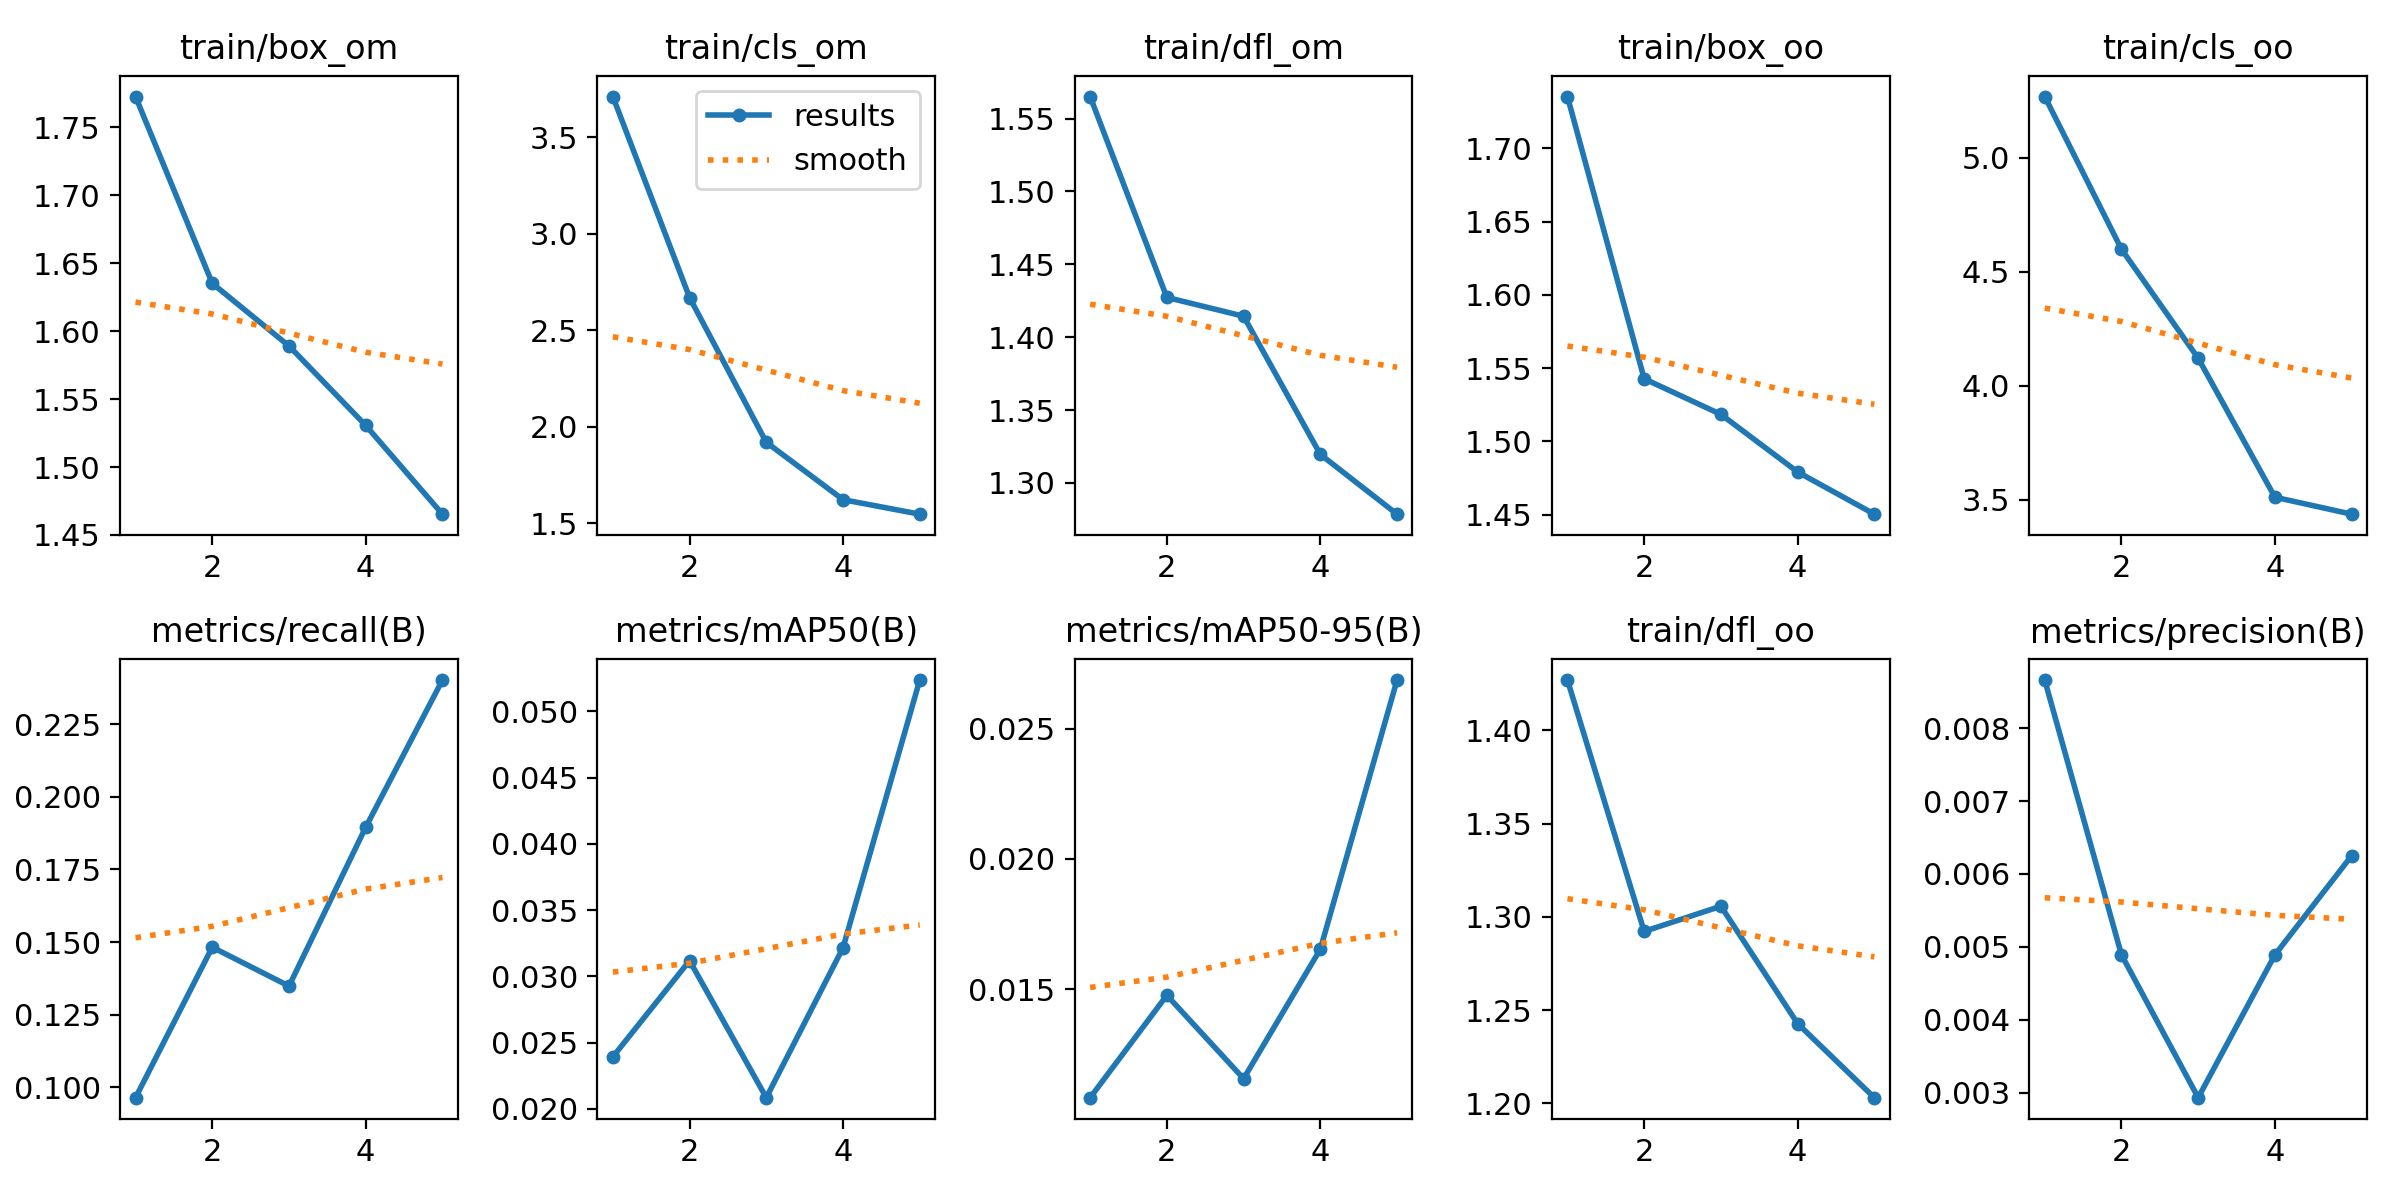

In [6]:
%cd {HOME}

#Display Confusion matrix
from IPython.display import Image
Image(filename=f'{OUTPUT_PATH}/confusion_matrix.png', width=600)
Image(filename=f'{OUTPUT_PATH}/results.png', width=600)

# Compare Pre-trained and Trained Model

## Prepare Dataset for validation
We need to have a version of the matches the coco dataset on which the pre-trained model was trained on. For example: The custom dataset has one class of 'sheep' at index '0'. But the pre-trained model was trained on 80 classes where 'person' has index '0', and sheep has index '18'. With the validation dataset, the `/labels/` directory has the actual class stored.

The pretrained model will go through the imageset. It will detect an object of index '18'. The (unedited) validation set will say the object belongs to class of index '0' and therefore an inaccurate detection. Thus, the original dataset needs to be converted the the coco class index. All the sheep instances of index '0', should now be changed to index '18'.

In [7]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

#Create Dataset folder
COCO_DATASET_DIR = DATASET_DIR + '_COCO'
COCO_DATASET_YAML_PATH = COCO_DATASET_DIR + '/data.yaml'
print(COCO_DATASET_YAML_PATH)

#Create a copy
!cp -r {DATASET_DIR} {COCO_DATASET_DIR}

#Remove all *.cache files
%cd {COCO_DATASET_DIR}
!rm -r train/*.cache valid/*.cache test/*.cache
%cd {HOME}

/content/datasets/animal-detection-5_COCO/data.yaml
/content/datasets/animal-detection-5_COCO
rm: cannot remove 'test/*.cache': No such file or directory
/content


In [8]:
#Create new YAMl file to describe COCO classes for pre-trained model
COCO_CLASS_list = [
    "0: person",
    "1: bicycle",
    "2: car",
    "3: motorcycle",
    "4: airplane",
    "5: bus",
    "6: train",
    "7: truck",
    "8: boat",
    "9: traffic light",
    "10: fire hydrant",
    "11: stop sign",
    "12: parking meter",
    "13: bench",
    "14: bird",
    "15: cat",
    "16: dog",
    "17: horse",
    "18: sheep",
    "19: cow",
    "20: elephant",
    "21: bear",
    "22: zebra",
    "23: giraffe",
    "24: backpack",
    "25: umbrella",
    "26: handbag",
    "27: tie",
    "28: suitcase",
    "29: frisbee",
    "30: skis",
    "31: snowboard",
    "32: sports ball",
    "33: kite",
    "34: baseball bat",
    "35: baseball glove",
    "36: skateboard",
    "37: surfboard",
    "38: tennis racket",
    "39: bottle",
    "40: wine glass",
    "41: cup",
    "42: fork",
    "43: knife",
    "44: spoon",
    "45: bowl",
    "46: banana",
    "47: apple",
    "48: sandwich",
    "49: orange",
    "50: broccoli",
    "51: carrot",
    "52: hot dog",
    "53: pizza",
    "54: donut",
    "55: cake",
    "56: chair",
    "57: couch",
    "58: potted plant",
    "59: bed",
    "60: dining table",
    "61: toilet",
    "62: TV",
    "63: laptop",
    "64: mouse",
    "65: remote",
    "66: keyboard",
    "67: cell phone",
    "68: microwave",
    "69: oven",
    "70: toaster",
    "71: sink",
    "72: refrigerator",
    "73: book",
    "74: clock",
    "75: vase",
    "76: scissors",
    "77: teddy bear",
    "78: hair drier",
    "79: toothbrush"
]

#Remove previous YAML file
!rm {COCO_DATASET_YAML_PATH}

#Write new YAML file with COCO classes
with open(COCO_DATASET_YAML_PATH, 'a') as file:
    file.write("names:\n")
    for item in COCO_CLASS_list:
        file.write(f"  {item}\n")
    file.write("\ntest: ../test/images\ntrain: ../train/images\nval: ../valid/images")

In [9]:
# Define the mapping of the numbers
number_mapping = {
    '0': '19',      # Dataset ID : COCO ID
    '1': '16',
    '2': '20',
    '3': 'remove',
    '4': 'remove',
}

# Define the folder containing the label files
label_folder = COCO_DATASET_DIR + '/valid/labels'

# Process each file in the label folder
for filename in os.listdir(label_folder):
    file_path = os.path.join(label_folder, filename)
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Replace numbers in each line
    new_lines = []
    for line in lines:
        components = line.strip().split()
        if components[0] in number_mapping:
              new_value = number_mapping[components[0]]
              if new_value == 'remove':
                    continue  # Skip this line if marked for removal
              else:
                    components[0] = number_mapping[components[0]]
                    new_line = ' '.join(components)
                    new_lines.append(new_line)

    # Write the modified contents back to the file
    with open(file_path, 'w') as file:
        file.write('\n'.join(new_lines) + '\n')

print('Number replacement complete.')

Number replacement complete.


In [10]:
%cd {HOME}
from ultralytics import YOLOv10

#Get model paths
TRAINED_MODEL_PATH      = f'{OUTPUT_PATH}/weights/best.pt'


#pretrained_model.classes = [18]
trained_model    = YOLOv10(TRAINED_MODEL_PATH)

#Validate trained model with 'test' data
trained_model_metrics = trained_model.val(
    data=DATASET_YAML_PATH,     #Specifies the path to the dataset configuration (yaml) file
    imgsz=640,                  #Defines the size of input images
    batch=16,          	        #Sets the number of images per batch. Use -1 for AutoBatch, which automatically adjusts based on GPU memory availability.
    save_json=True,            #If True, saves the results to a JSON file for further analysis or integration with other tools.
    save_hybrid=False,          #If True, saves a hybrid version of labels that combines original annotations with additional model predictions.
    conf=0.5, 	                #Sets the minimum confidence threshold for detections. Detections with confidence below this threshold are discarded.
    iou=0.6, 	                  #Sets the Intersection Over Union (IoU) threshold for Non-Maximum Suppression (NMS). Helps in reducing duplicate detections.
    max_det=50, 	              #Limits the maximum number of detections per image. Useful in dense scenes to prevent excessive detections.
    half=True, 	                #Enables half-precision (FP16) computation, reducing memory usage and potentially increasing speed with minimal impact on accuracy.
    device=None, 	              #Specifies the device for validation (cpu, cuda:0, etc.). Allows flexibility in utilizing CPU or GPU resources.
    dnn=False, 	                #If True, uses the OpenCV DNN module for ONNX model inference, offering an alternative to PyTorch inference methods.
    plots=True,	                #When set to True, generates and saves plots of predictions versus ground truth for visual evaluation of the model's performance.
    rect=False, 	              #If True, uses rectangular inference for batching, reducing padding and potentially increasing speed and efficiency.
    split='val',               #Determines the dataset split to use for validation (val, test, or train).
)

#Define Models

PRETRAINED_MODEL_PATH   = MODEL_PATH
pretrained_model = YOLOv10(PRETRAINED_MODEL_PATH)

#Validate trained model with 'test' data
pretrained_model_metrics = pretrained_model.val(
    data=COCO_DATASET_YAML_PATH,     #Specifies the path to the dataset configuration (yaml) file
    imgsz=640,                  #Defines the size of input images
    batch=16,          	        #Sets the number of images per batch. Use -1 for AutoBatch, which automatically adjusts based on GPU memory availability.
    save_json=False,            #If True, saves the results to a JSON file for further analysis or integration with other tools.
    save_hybrid=True,          #If True, saves a hybrid version of labels that combines original annotations with additional model predictions.
    conf=0.5, 	                #Sets the minimum confidence threshold for detections. Detections with confidence below this threshold are discarded.
    iou=0.6, 	                  #Sets the Intersection Over Union (IoU) threshold for Non-Maximum Suppression (NMS). Helps in reducing duplicate detections.
    max_det=50, 	              #Limits the maximum number of detections per image. Useful in dense scenes to prevent excessive detections.
    half=True, 	                #Enables half-precision (FP16) computation, reducing memory usage and potentially increasing speed with minimal impact on accuracy.
    device=None, 	              #Specifies the device for validation (cpu, cuda:0, etc.). Allows flexibility in utilizing CPU or GPU resources.
    dnn=False, 	                #If True, uses the OpenCV DNN module for ONNX model inference, offering an alternative to PyTorch inference methods.
    plots=True,	                #When set to True, generates and saves plots of predictions versus ground truth for visual evaluation of the model's performance.
    rect=False, 	              #If True, uses rectangular inference for batching, reducing padding and potentially increasing speed and efficiency.
    split='val',               #Determines the dataset split to use for validation (val, test, or train).
    #classes=[17,18,19],         #17 - Horse, 18- Sheep, 19- Cow
)

/content
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2696366 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /content/datasets/animal-detection-5/valid/labels.cache... 308 images, 62 backgrounds, 0 corrupt: 100%|██████████| 308/308 [00:00<?, ?it/s]
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


                   all        308       1792     0.0245      0.147     0.0604     0.0317
                Cattle        308        742     0.0192    0.00809    0.00986    0.00397
                   Dog        308         69    0.00709     0.0435     0.0255     0.0153
                  Goat        308        782     0.0489      0.532      0.195      0.105
                Monkey        308        199     0.0227    0.00503     0.0115    0.00229
Speed: 0.6ms preprocess, 4.6ms inference, 0.0ms loss, 0.1ms postprocess per image
Saving runs/detect/val/predictions.json...
Results saved to runs/detect/val
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2762608 parameters, 63840 gradients, 8.6 GFLOPs


val: Scanning /content/datasets/animal-detection-5_COCO/valid/labels... 308 images, 208 backgrounds, 0 corrupt: 100%|██████████| 308/308 [00:00<00:00, 1064.74it/s]


val: New cache created: /content/datasets/animal-detection-5_COCO/valid/labels.cache


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:08<00:00,  2.34it/s]


                   all        308        811      0.294      0.276      0.225      0.115
                   dog        308         69      0.196     0.0284     0.0483     0.0334
                   cow        308        742      0.391      0.524      0.402      0.196
Speed: 2.9ms preprocess, 11.6ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val2


**NOTE:** Let's randomly select an image from our validation set and visualize the results.

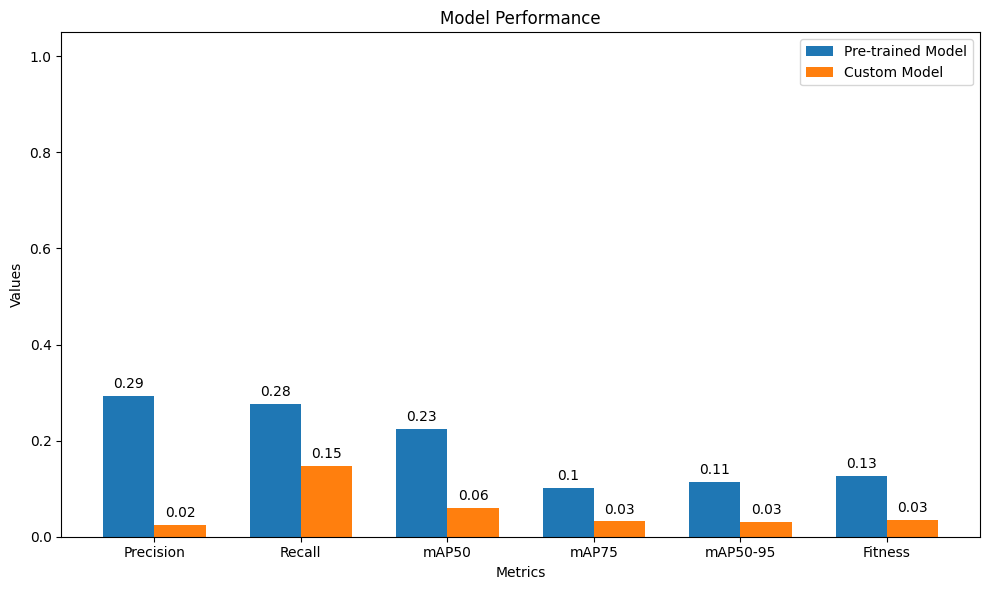

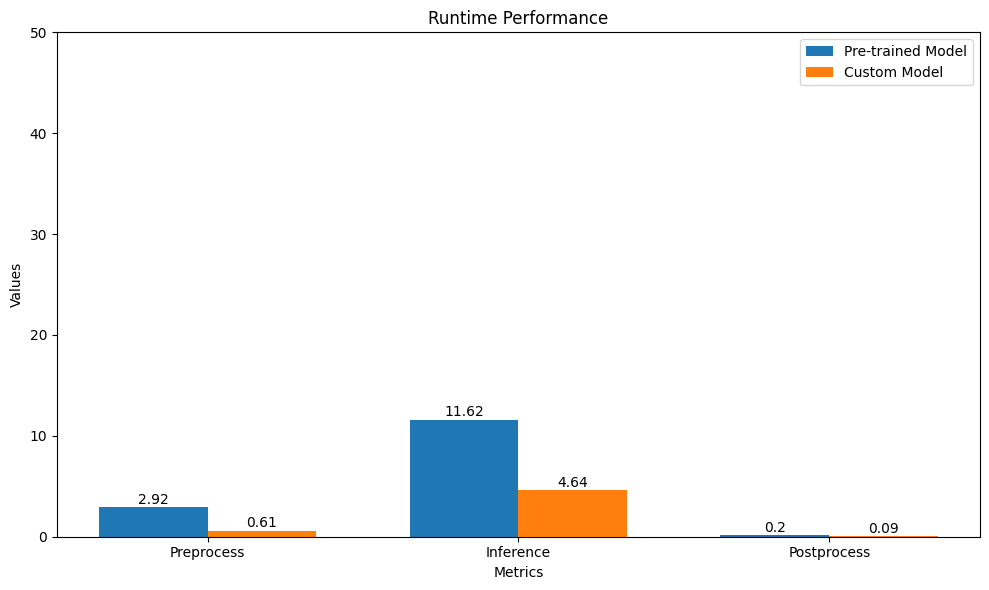

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_metrics_comparison(title,model1_name,model1_metrics,model2_name, model2_metrics,min,max):
    metrics = list(model2_metrics.keys())
    model2_values = [model2_metrics[metric] for metric in metrics]
    model1_values = []
    for metric in metrics :
      if str(metric) in model1_metrics:
          model1_values.append(model1_metrics[metric])
      else:
          model1_values.append(0)
    #model2_values = [model2_metrics[metric] for metric in metrics]
    x = range(len(metrics))

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35

    bars1 = ax.bar(x, model1_values, width=bar_width, label=model1_name, align='center')
    bars2 = ax.bar([p + bar_width for p in x], model2_values, width=bar_width, label=model2_name, align='center')

    # Add text annotations for Model 1
    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

    # Add text annotations for Model 2
    for bar in bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.set_xticks([p + bar_width / 2 for p in x])
    ax.set_xticklabels(metrics)
    ax.set_ylim(min, max)  # All metrics values range between 0 and 1
    ax.legend()

    plt.tight_layout()
    plt.show()

#Pretrained Model Metric Allocation
PT_box = pretrained_model_metrics.box
PT_box_metrics = {
    'Precision'   : PT_box.mp,
    'Recall'      : PT_box.mr,
    'mAP50'       : PT_box.map50,
    'mAP75'       : PT_box.map75,
    'mAP50-95'    : PT_box.map,
    'Fitness'     : PT_box.fitness(),
}

PT_speed = pretrained_model_metrics.speed
PT_speed_metrics ={
    'Preprocess'  : PT_speed['preprocess'],
    'Inference'   : PT_speed['inference'],
    'Postprocess' : PT_speed['postprocess'],
}

#Trained Model Metric Allocation
TR_box = trained_model_metrics.box
TR_speed = trained_model_metrics.speed
TR_box_metrics = {
    'Precision'   : TR_box.mp,
    'Recall'      : TR_box.mr,
    'mAP50'       : TR_box.map50,
    'mAP75'       : TR_box.map75,
    'mAP50-95'    : TR_box.map,
    'Fitness'     : TR_box.fitness(),
}
TR_speed_metrics ={
    'Preprocess'  : TR_speed['preprocess'],
    'Inference'   : TR_speed['inference'],
    'Postprocess' : TR_speed['postprocess'],
}

plot_metrics_comparison('Model Performance' ,'Pre-trained Model',PT_box_metrics,'Custom Model',TR_box_metrics,0,1.05)
plot_metrics_comparison('Runtime Performance','Pre-trained Model',PT_speed_metrics,'Custom Model',TR_speed_metrics,0,50)

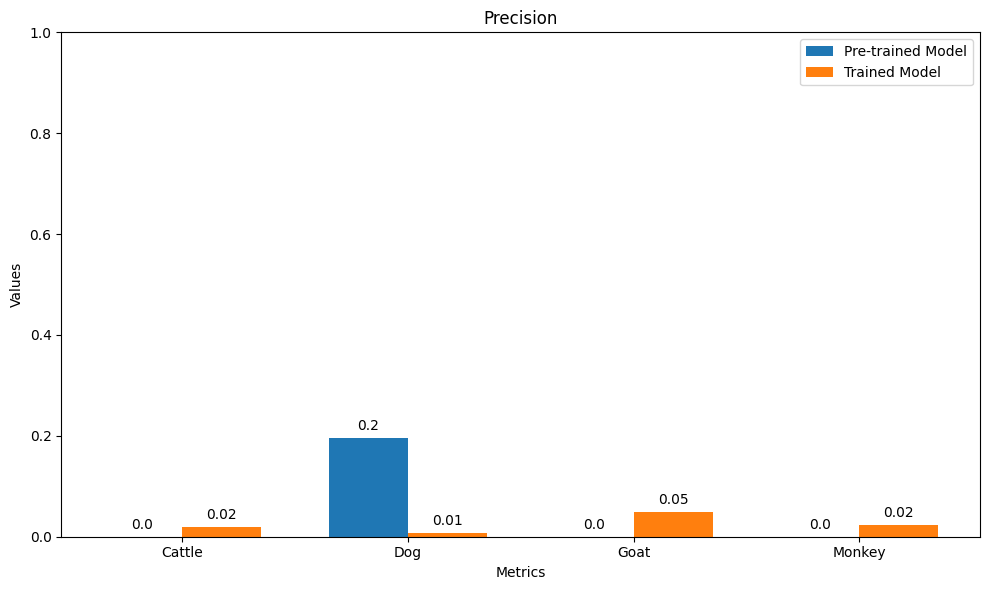

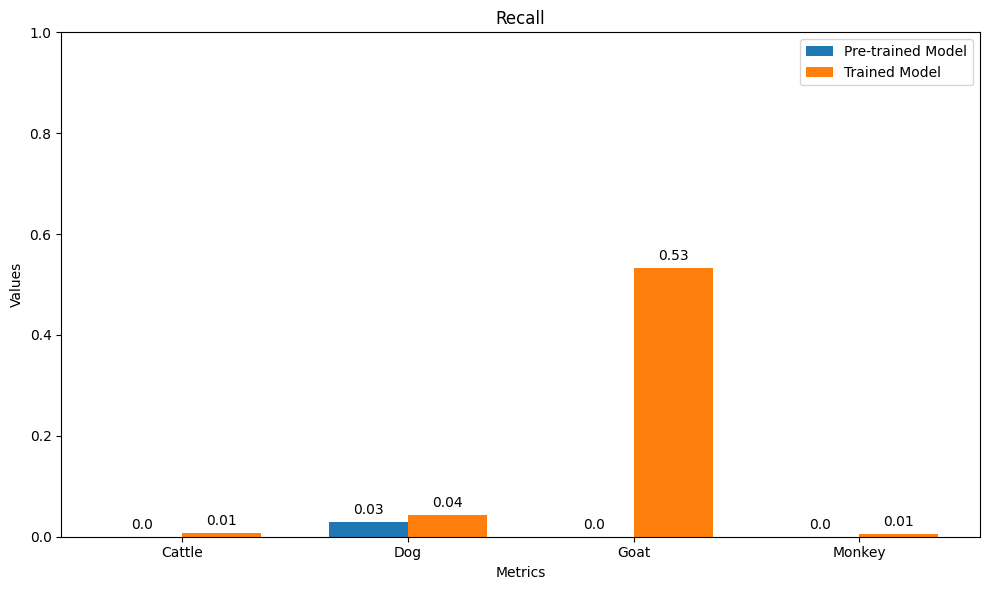

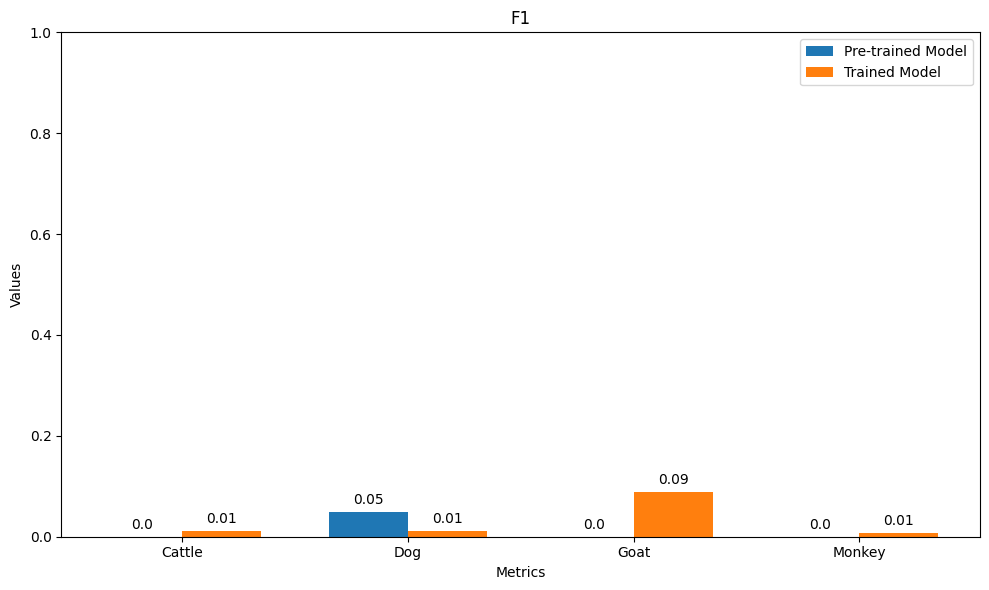

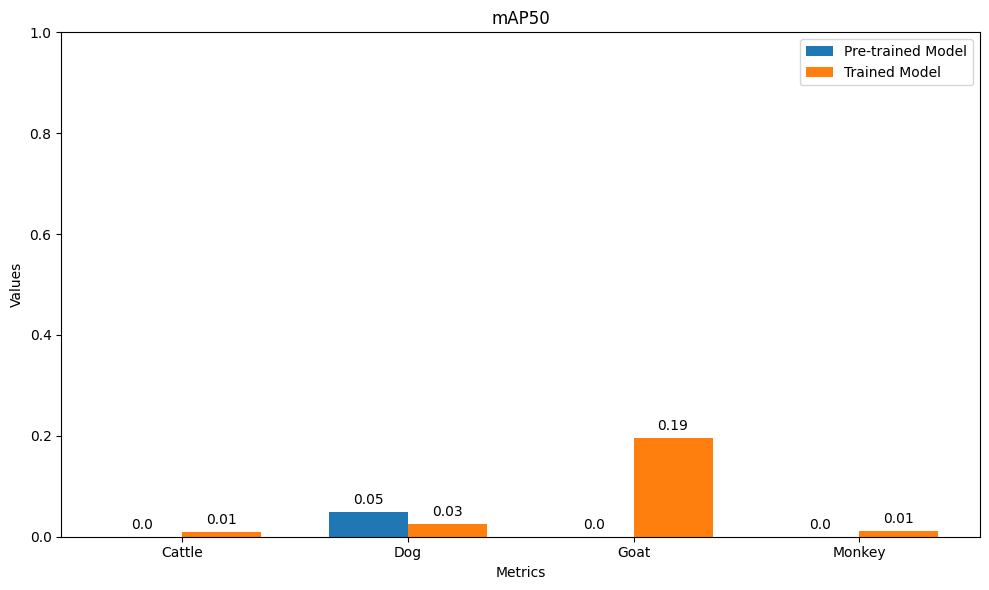

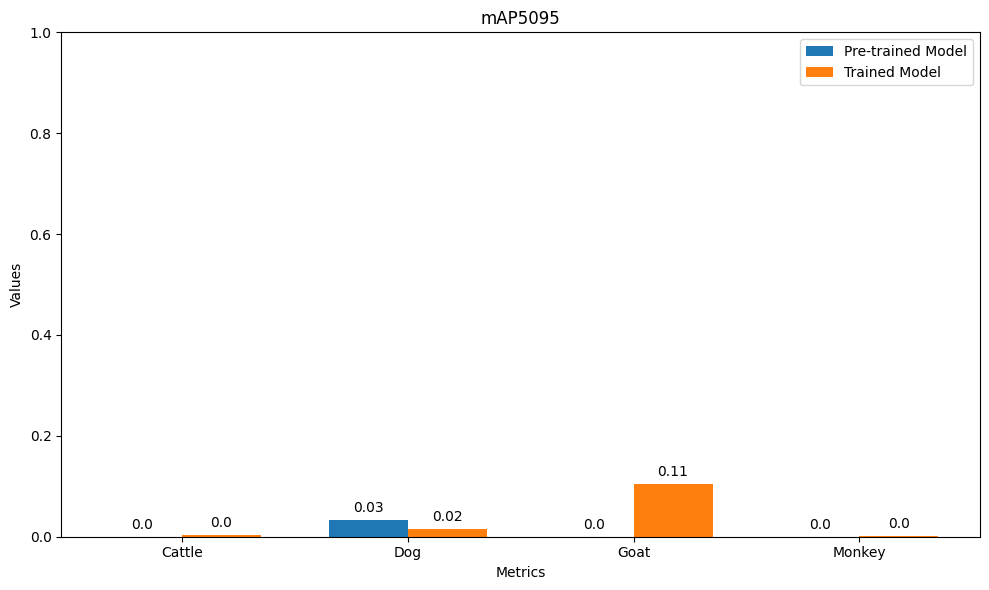

In [36]:
class ResultSummary:
    # Constructor to initialize the object
    def __init__(self,val):
        self.Precision = {}
        self.Recall = {}
        self.F1 = {}
        self.mAP50 = {}
        self.mAP5095 = {}

        for i, c in enumerate(val.box.ap_class_index):
            self.Precision[val.names[c].capitalize()]    = val.box.p[i]      #val.box.class_result(i)[0]
            self.Recall[val.names[c].capitalize()]       = val.box.r[i]      #val.box.class_result(i)[1]
            self.F1[val.names[c].capitalize()]           = val.box.f1[i]
            self.mAP50[val.names[c].capitalize()]        = val.box.ap50[i]   #val.box.class_result(i)[2]
            self.mAP5095[val.names[c].capitalize()]      = val.box.ap[i]     #val.box.class_result(i)[3]

PT_result = ResultSummary(pretrained_model_metrics)
TR_result = ResultSummary(trained_model_metrics)

#Per Class Metrics
plot_metrics_comparison('Precision','Pre-trained Model',PT_result.Precision,'Trained Model',TR_result.Precision,0,1)
plot_metrics_comparison('Recall','Pre-trained Model',PT_result.Recall,'Trained Model',TR_result.Recall,0,1)
plot_metrics_comparison('F1','Pre-trained Model',PT_result.F1,'Trained Model',TR_result.F1,0,1)
plot_metrics_comparison('mAP50','Pre-trained Model',PT_result.mAP50,'Trained Model',TR_result.mAP50,0,1)
plot_metrics_comparison('mAP5095','Pre-trained Model',PT_result.mAP5095,'Trained Model',TR_result.mAP5095,0,1)